In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from cmcrameri import cm
import datetime
from scipy.signal import savgol_filter
os.chdir('/users/marianne/documents/pe_snow_fires/ICB')
fig_dir = '/users/marianne/documents/pe_snow_fires/ICB/'

In [213]:
np.nanmax(hourlyA[hourlyA.keys()[0]])

139.662

In [2]:
def add_datetime(hobo,station):
    kh = hobo.keys()
    hobo['dt']=pd.to_datetime(hobo[kh[1]])
    station['dt'] = pd.to_datetime(station['TIMESTAMP'])


In [3]:
## read in all data
hoboA = pd.read_csv('hoboA1.csv',header=1)
hoboB = pd.read_csv('hoboB1.csv',header=1)
hoboC = pd.read_csv('hoboC1.csv',header=1)
stationA = pd.read_csv('TableA1.csv',header=0)
stationB = pd.read_csv('TableB1.csv',header=0)
stationC = pd.read_csv('TableC1.csv',header=0)

cameraA = pd.read_csv('snow_summary_A.csv',header=2)
cameraB = pd.read_csv('snow_summary_B.csv',header=2)
cameraC = pd.read_csv('snow_summary_C.csv',header=2)

add_datetime(hoboA,stationA)
add_datetime(hoboB,stationB)
add_datetime(hoboC,stationC)

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [256]:
def resample_prep(hobo,station,camera):
    kh = hobo.keys()
    ks = station.keys()
    idx_s = [6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26]
    hobo.index = hobo['dt']
    station.index = station['dt']
    index_hr = hobo[kh[6]].resample('1H').bfill().index
    index_day = hobo[kh[6]].resample('24H').bfill().index
    hourly = pd.DataFrame(index=index_hr)
    daily = pd.DataFrame(index = index_day)
    for k in kh[2:4]:
        tmp = pd.Series(hobo[k])
        tmp.index = hobo['dt']
        tmp_hourly = tmp.resample('1H').interpolate()
        if k==kh[2]:  
            tmp_c = (tmp_hourly-32) * 5/9
            tmp_c.name = 'tempC'
            hourly = hourly.join(pd.DataFrame(tmp_c))
        hourly = hourly.join(pd.DataFrame(tmp_hourly))

    for k in ks[idx_s]:
        tmp = pd.Series(station[k].astype('float'))
        tmp.index = station['dt']
        try:
            idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
            tmp = tmp.drop(idx)
        except:
            continue
        tmp_hourly = tmp.resample('1H').interpolate() # bfill()
        hourly = hourly.join(pd.DataFrame(tmp_hourly))


    for k in kh[2:4]:
        tmp = pd.Series(hobo[k])
        tmp.index = hobo['dt']
        tmp_daily = tmp.resample('24H').mean()
        if k==kh[2]:  
            tmp_c = (tmp_daily-32) * 5/9
            tmp_c.name = 'tempC'
            daily = daily.join(pd.DataFrame(tmp_c))
        daily = daily.join(pd.DataFrame(tmp_daily))

    for k in ks[idx_s]:
        tmp = pd.Series(station[k].astype('float'))
        tmp.index = station['dt']
        idx = np.nan
        try:
            idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
            tmp = tmp.drop(idx)
        except:
            continue
        tmp_daily = tmp.resample('24H').mean()
        daily = daily.join(pd.DataFrame(tmp_daily))

    camera['dt'] = pd.to_datetime(camera['Date'])
    camera_wy20 = camera[camera['dt']>hobo['dt'][0]]
    camera_wy20.index = camera_wy20['dt']
    
    return hourly, daily, camera_wy20


In [243]:
hobo = hoboA
station = stationA
idx_s = [6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26]
kh = hobo.keys()
ks = station.keys()
hobo.index = hobo['dt']
station.index = station['dt']
index_hr = hobo[kh[6]].resample('1H').bfill().index
index_day = hobo[kh[6]].resample('24H').bfill().index
hourly = pd.DataFrame(index=index_hr)
daily = pd.DataFrame(index = index_day)
for k in kh[2:4]:
    tmp = pd.Series(hobo[k]).astype('float')
    tmp.index = hobo['dt']
    tmp_hourly = tmp.resample('1H').bfill()
    print(k)
    if k=='Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)':  
        tmp_c = (tmp_hourly-32) * 5/9
        tmp_c.name = 'tempc'
        hourly = hourly.join(pd.DataFrame(tmp_c))
    hourly = hourly.join(pd.DataFrame(tmp_hourly))
for k in ks[idx_s]:
    tmp = pd.Series(station[k]).astype('float')
    tmp.index = station['dt']
    try:
        idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
        tmp = tmp.drop(idx)
    except:
        continue
    tmp_hourly = tmp.resample('1H').mean() # bfill()
    # tmp_hourly.column = k
    hourly = hourly.join(pd.DataFrame(tmp_hourly))

Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)
Intensity, lum/ft² (LGR S/N: 20947454, SEN S/N: 20947454)


In [257]:
hourlyA, dailyA, cameraA = resample_prep(hoboA, stationA, cameraA)
hourlyB, dailyB, cameraB = resample_prep(hoboB, stationB, cameraB)
hourlyC, dailyC, cameraC = resample_prep(hoboC, stationC, cameraC)

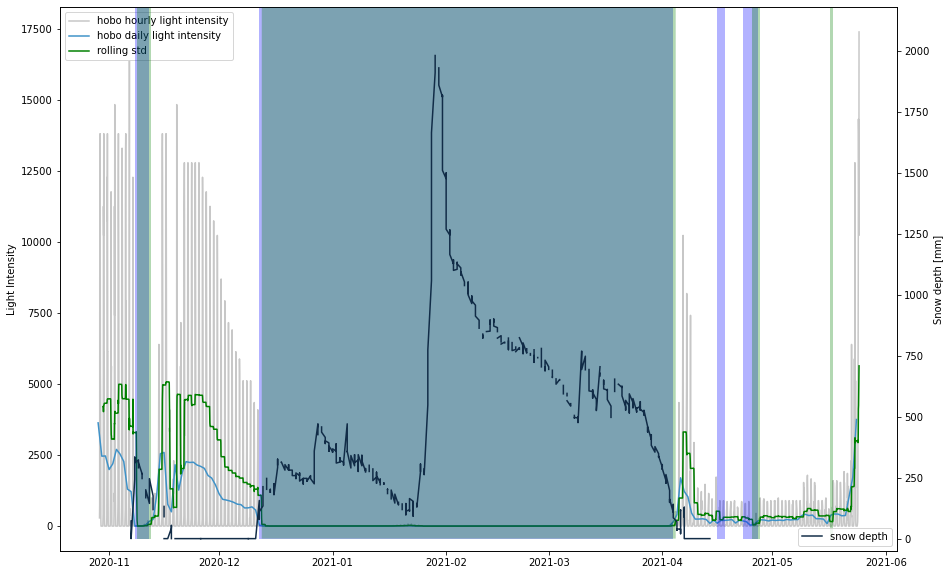

In [223]:
hourly, daily, camera, fig_name = hourlyB, dailyB, cameraB, 'snow_light_B.jpg'
kh = hourly.keys()
cols = cm.bukavu(np.linspace(0,1,5))

y = hourly[kh[1]].astype('float')
x = hourly.index

y2 = daily[kh[1]]
x2 = daily.index

smooth = savgol_filter(y, window_length = 25, polyorder = 1)
smooth = savgol_filter(smooth, window_length = 11, polyorder = 1)
fig,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(x,y,color=cm.grayC(50),label='hobo hourly light intensity')
ax.plot(x2,y2,color=cols[1],label='hobo daily light intensity')
ax2.fill_between(x2,0,2500,where=y2<200,facecolor='blue',alpha=0.3)
ax2.set_ylim(-50,1.1*np.nanmax(camera['Snow Depth (mm)']))
# y.rolling(window=24).mean().plot(style='k', ax=ax, label='rolling mean')
y_std = y.rolling(window=24).std()# .plot(style='g', ax=ax, label='rolling std')
ax.plot(y_std,color='g',label='rolling std')
ax2.fill_between(y_std.index,0,2500,where=y_std<200,facecolor='green',alpha=0.3)
ax2.plot(camera['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('Light Intensity')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
plt.show()
# fig.savefig(fig_dir + fig_name)


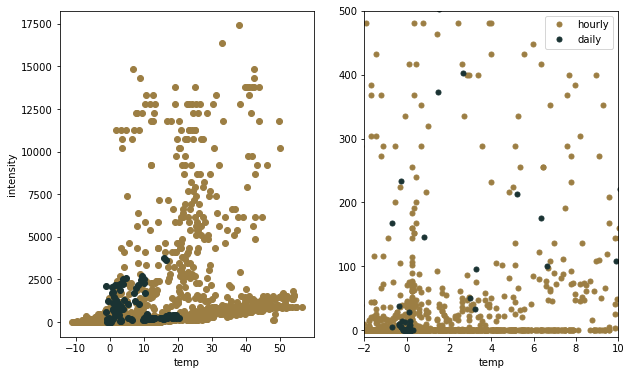

In [269]:
hourly = hourlyB
daily = dailyB
figname = 'temp_intensity_B.jpg'

fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(hourly['tempC'],hourly[hourly.keys()[2]],'o',label='hourly',color=cols[3])
ax[0].plot(daily['tempC'],daily[daily.keys()[2]],'o',label='daily',color=cols[0])

ax[1].plot(hourly['tempC'],hourly[hourly.keys()[2]],'o',markersize=5,label='hourly',color=cols[3])
ax[1].plot(daily['tempC'],daily[daily.keys()[2]],'o',markersize=5,label='daily',color=cols[0])
ax[1].set_ylim(-10,500)
ax[1].set_xlim(-2,10)
ax[0].set_xlabel('temp')
ax[1].set_xlabel('temp')
ax[0].set_ylabel('intensity')
plt.legend()
plt.savefig(figname)

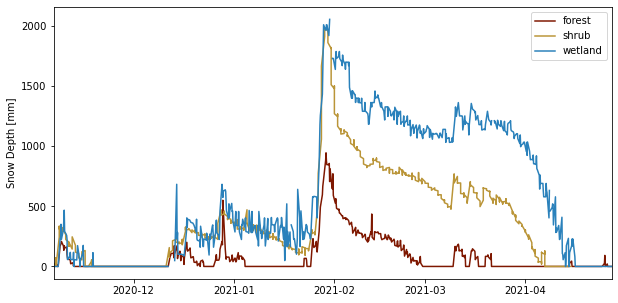

In [283]:
cols = cm.roma(np.linspace(0,1,12))
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(cameraA['Snow depth gap-filled'],label ='forest',color=cols[0])
ax.plot(cameraB['Snow depth gap-filled'],label = 'shrub',color=cols[3])
ax.plot(cameraC['Snow depth gap-filled'], label='wetland',color=cols[9])
ax.set_xlim(cameraA.index[0],cameraA.index[-1])
ax.set_ylabel('Snow Depth [mm]')
plt.legend()
plt.show()
fig.savefig('snow_depth_cameras.png')

In [271]:
cameraA

,Date,Time,Snow Depth (mm),Snow depth gap-filled,Snowfall (mm),Snow Depth (mm).1,Snow Depth (mm).2,dt
dt,,,,,,,,
2020-11-06 07:00:00,11/6/20 7:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2020-11-06 07:00:00
2020-11-06 10:00:00,11/6/20 10:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2020-11-06 10:00:00
2020-11-06 13:00:00,11/6/20 13:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2020-11-06 13:00:00
2020-11-06 16:00:00,11/6/20 16:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2020-11-06 16:00:00
2020-11-07 07:00:00,11/7/20 7:00,NaN,12.979146,12.979146,12.979146,NaN,NaN,2020-11-07 07:00:00
...,...,...,...,...,...,...,...,...
2021-04-26 16:00:00,4/26/21 16:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2021-04-26 16:00:00
2021-04-27 07:00:00,4/27/21 7:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2021-04-27 07:00:00
2021-04-27 10:00:00,4/27/21 10:00,NaN,0.000000,0.000000,0.000000,NaN,NaN,2021-04-27 10:00:00


Index(['Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)',
       'Intensity, lum/ft² (LGR S/N: 20947454, SEN S/N: 20947454)',
       'Rain_mm_Tot', 'AirTC_Avg', 'RH', 'SlrkW_Avg', 'SlrMJ_Tot', 'WS_ms_Max',
       'WindDir', 'ETos', 'VWC_Avg', 'EC_Avg', 'T_Avg', 'VWC_2_Avg',
       'EC_2_Avg', 'T_2_Avg', 'VWC_3_Avg', 'EC_3_Avg', 'T_3_Avg', 'WS_ms',
       'WS_ms_Avg'],
      dtype='object')

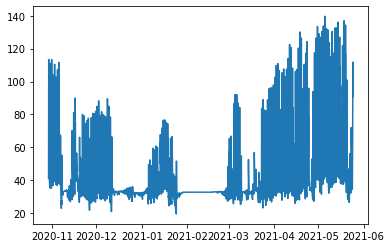

In [215]:
plt.plot(hourlyA[hourlyA.keys()[0]])

In [4]:
hobo = pd.read_csv('hoboA1.csv',header=1)

hobo['dt']=pd.to_datetime(hobo[kh[1]])

station = pd.read_csv('TableA1.csv',header=0)
station['dt'] = pd.to_datetime(station['TIMESTAMP'])
ks = station.keys()
station_wy20 = station[station['dt']>hobo['dt'][0]]

Text(0.5, 0, 'temp')

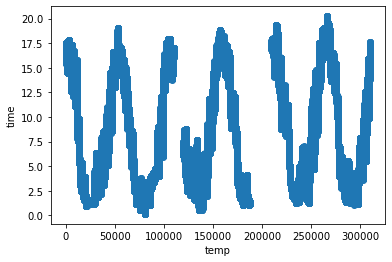

In [5]:
f,ax=plt.subplots()
ax.plot(station['T_Avg'],'o')
ax.set_ylabel('time')
ax.set_xlabel('temp')

Text(0.5, 0, 'intensity')

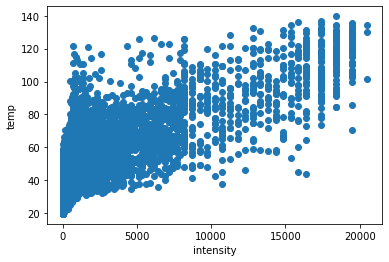

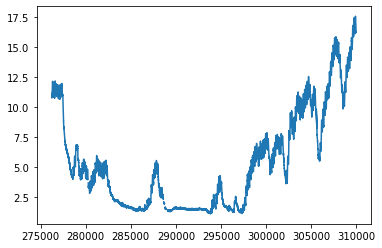

In [7]:
plt.plot(station_wy20['T_Avg'].astype('float'))

In [8]:
series=pd.Series(station_wy20['T_Avg'].astype('float'),index=station_wy20['dt'])

In [9]:
hobo_T=pd.Series(hobo[kh[2]])
hobo_T.index=hobo['dt']
station_T=pd.Series(station_wy20['AirTC_Avg'])
station_T.index = station_wy20['dt']

In [10]:
station_hourly = station_T.resample('1H').bfill()
hobo_hourly = hobo_T.resample('1H').bfill()
station_daily = station_T.resample('24H').bfill()
hobo_daily = hobo_T.resample('24H').bfill()

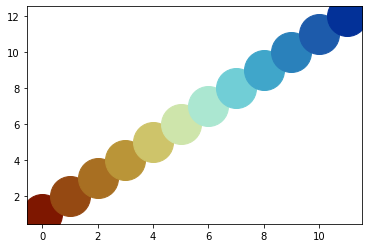

In [11]:
fig,ax=plt.subplots()
for i,val in enumerate(cm.roma(np.linspace(0,1,12))):
    ax.plot(i,i+1, 'o',markersize=40,color=val)

In [12]:
hourly_temps = pd.DataFrame(hobo_hourly).join(pd.DataFrame(station_hourly))
hourly_temps.columns=['hobo','station']
daily_temps = pd.DataFrame(hobo_daily).join(pd.DataFrame(station_daily))
daily_temps.columns=['hobo','station']


In [13]:
hourly_temps['hobo c'] = (hourly_temps['hobo'] - 32) / 1.8  
hourly_temps['difference'] = hourly_temps['station'].astype('float')-hourly_temps['hobo c']
series=pd.Series(station_wy20['AirTC_Avg'].astype('float'))

daily_temps['hobo c'] = (daily_temps['hobo'] - 32) / 1.8  
daily_temps['difference'] = daily_temps['station'].astype('float')-daily_temps['hobo c']

In [14]:
camera = pd.read_csv('snow_summary.csv',header=2)
camera['dt'] = pd.to_datetime(camera['Date'])
camera_wy20 = camera[camera['dt']>hobo['dt'][0]]
camera_wy20.index = camera_wy20['dt']


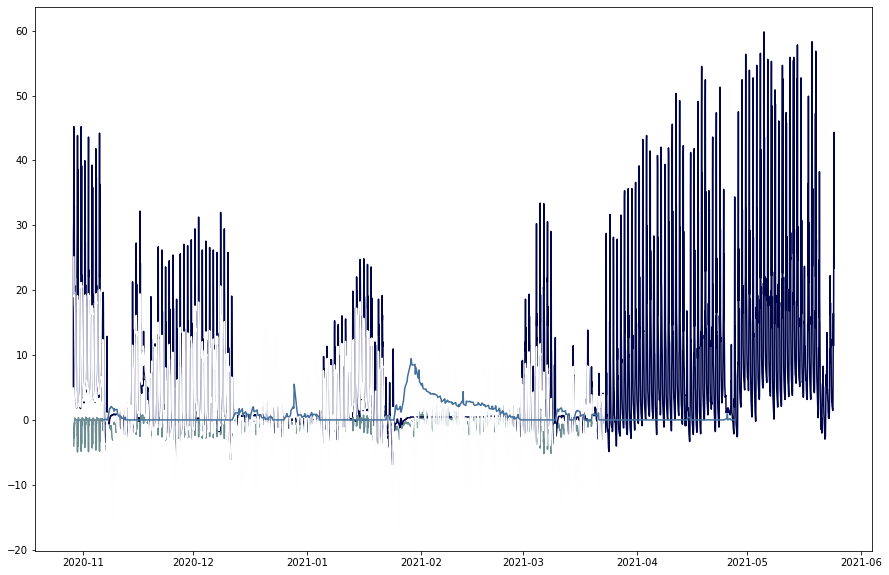

In [15]:
cols = cm.davos(np.linspace(0,1,7))
f,ax=plt.subplots(figsize=(15,10))
ax.plot(hourly_temps['difference']/5,'-',color=cols[3])

ax.plot(hourly_temps['hobo c'].astype('float'),color=cols[0])
ax.plot(hourly_temps['station'].astype('float'),color=cols[6])
ax.plot(camera_wy20['Snow Depth (mm)']/100,color=cols[2])

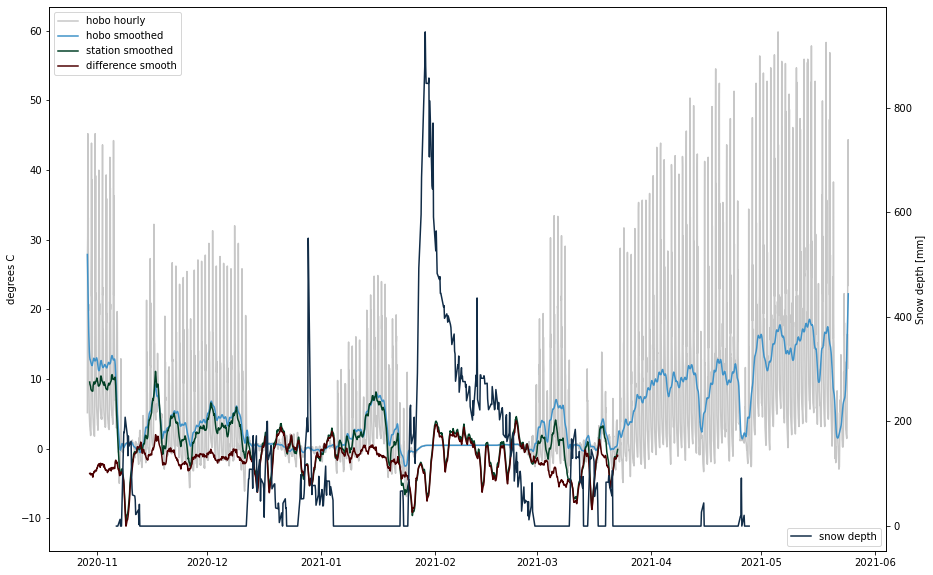

In [16]:
cols = cm.bukavu(np.linspace(0,1,5))


y = hourly_temps['hobo c'].astype('float')
x = hourly_temps.index
smooth = savgol_filter(y, window_length = 25, polyorder = 1)
smooth = savgol_filter(smooth, window_length = 11, polyorder = 1)
f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(x,y,color=cm.grayC(50),label='hobo hourly')
ax.plot(x,smooth,color=cols[1],label='hobo smoothed')
smooth_station = savgol_filter(hourly_temps['station'].astype('float'), window_length = 25, polyorder = 1)
tmp =  smooth_station - smooth
ax.plot(x,smooth_station,color=cols[2],label='station smoothed')
ax.plot(x,tmp, color=cm.bilbao(255),label = 'difference smooth')
ax2.plot(camera_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('degrees C')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')

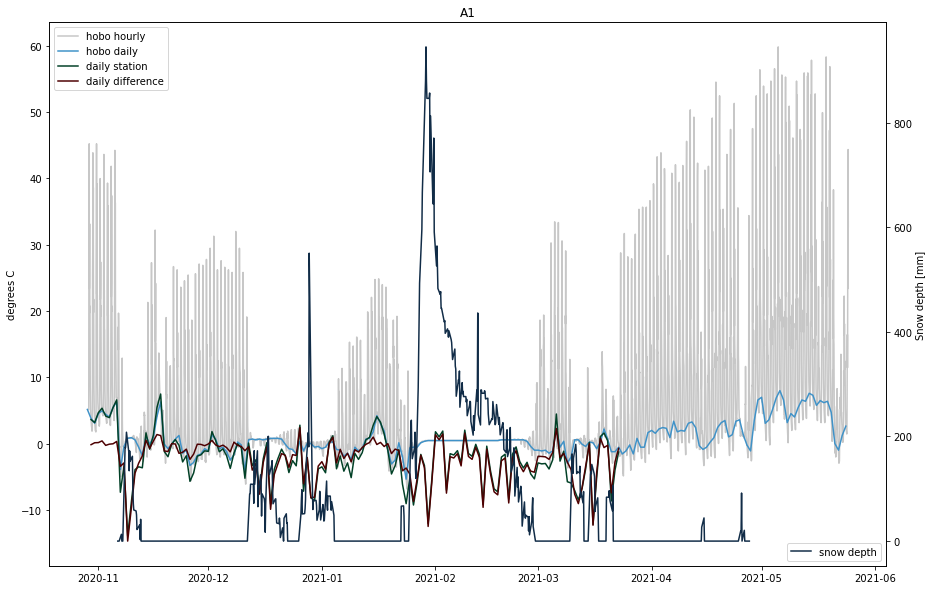

In [17]:
cols = cm.bukavu(np.linspace(0,1,5))
y = daily_temps['hobo c'].astype('float')
x = daily_temps.index

f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(hourly_temps.index,hourly_temps['hobo c'],color=cm.grayC(50),label='hobo hourly')
ax.plot(x,y,color=cols[1],label='hobo daily')
daily_station = daily_temps['station'].astype('float') #  savgol_filter(hourly_temps['station'].astype('float'), window_length = 1, polyorder = 1)
tmp =  daily_station - y
ax.plot(x,daily_station,color=cols[2],label='daily station')
ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('degrees C')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
ax.set_title('A1')
plt.savefig("snow_temp_a1_air.jpg", dpi=300)

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


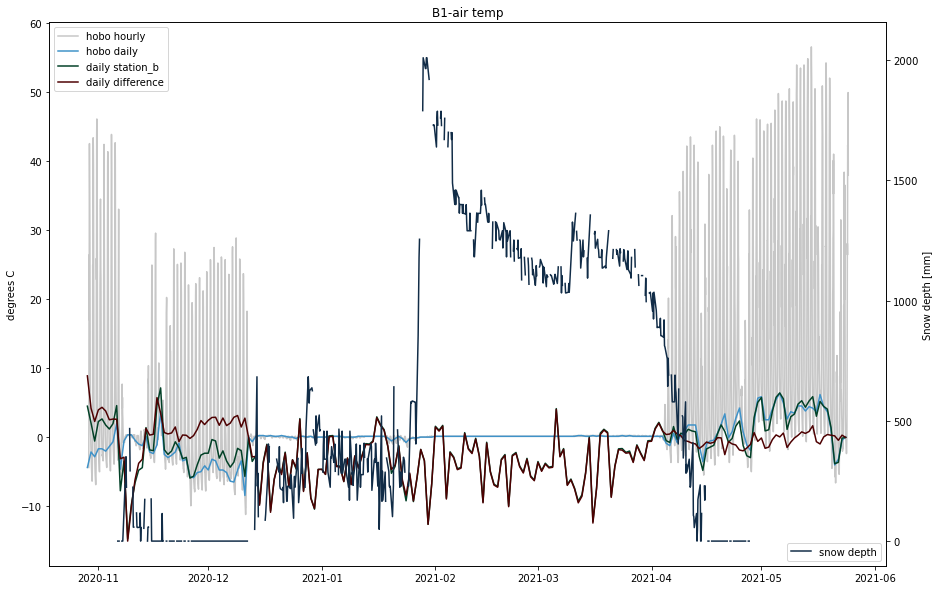

In [18]:

hobo_b = pd.read_csv('hoboB1.csv',header=1)
kh = hobo_b.keys()
hobo_b['dt']=pd.to_datetime(hobo_b[kh[1]])

station_b = pd.read_csv('TableB1.csv',header=0)
station_b['dt'] = pd.to_datetime(station_b['TIMESTAMP'])
ks = station_b.keys()
station_b_wy20 = station_b[station_b['dt']>hobo_b['dt'][0]]
hobo_b_T=pd.Series(hobo_b[kh[2]])
hobo_b_T.index=hobo_b['dt']
station_b_T=pd.Series(station_b_wy20['AirTC_Avg'])
station_b_T.index = station_b_wy20['dt']
station_b_hourly = station_b_T.resample('1H').bfill()
hobo_b_hourly = hobo_b_T.resample('1H').bfill()
station_b_daily = station_b_T.resample('24H').bfill()
hobo_b_daily = hobo_b_T.resample('24H').bfill()
hourly_temps_b = pd.DataFrame(hobo_b_hourly).join(pd.DataFrame(station_b_hourly))
hourly_temps_b.columns=['hobo','station_b']
daily_temps_b = pd.DataFrame(hobo_b_daily).join(pd.DataFrame(station_b_daily))
daily_temps_b.columns=['hobo','station_b']
hourly_temps_b['hobo c'] = (hourly_temps_b['hobo'] - 32) / 1.8  
hourly_temps_b['difference'] = hourly_temps_b['station_b'].astype('float')-hourly_temps_b['hobo c']
series=pd.Series(station_b_wy20['AirTC_Avg'].astype('float'))

daily_temps_b['hobo c'] = (daily_temps_b['hobo'] - 32) / 1.8  
daily_temps_b['difference'] = daily_temps_b['station_b'].astype('float')-daily_temps_b['hobo c']

camera_b = pd.read_csv('snowsummary_wetland.csv',header=2)
camera_b['dt'] = pd.to_datetime(camera_b['Date'])
camera_b_wy20 = camera_b[camera_b['dt']>hobo_b['dt'][0]]
camera_b_wy20.index = camera_b_wy20['dt']


cols = cm.bukavu(np.linspace(0,1,5))
y = daily_temps_b['hobo c'].astype('float')
x = daily_temps_b.index

f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(hourly_temps_b.index,hourly_temps_b['hobo c'],color=cm.grayC(50),label='hobo hourly')
ax.plot(x,y,color=cols[1],label='hobo daily')
daily_station_b = daily_temps_b['station_b'].astype('float') #  savgol_filter(hourly_temps_b['station_b'].astype('float'), window_length = 1, polyorder = 1)
tmp =  daily_station_b - y
ax.plot(x,daily_station_b,color=cols[2],label='daily station_b')
ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_b_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('degrees C')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
ax.set_title('B1-air temp')
plt.savefig("snow_temp_b1_air.jpg", dpi=300)

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, 'C1')

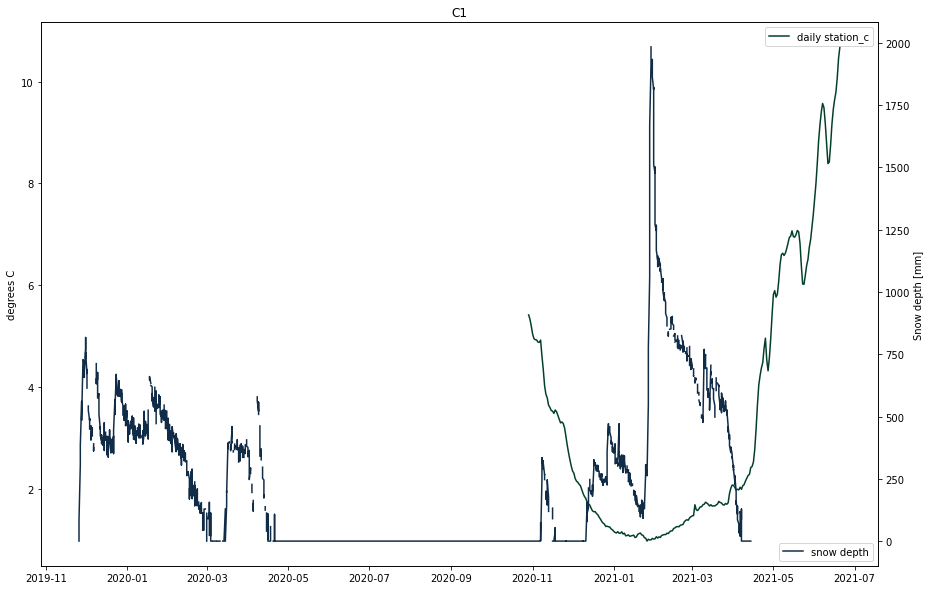

In [20]:

hobo_c = pd.read_csv('hoboC1.csv',header=1)
kh = hobo_c.keys()
hobo_c['dt']=pd.to_datetime(hobo_c[kh[1]])

station_c = pd.read_csv('TableC1.csv',header=0)
station_c['dt'] = pd.to_datetime(station_c['TIMESTAMP'])
ks = station_c.keys()
station_c_wy20 = station_c[station_c['dt']>hobo_b['dt'][0]]
hobo_c_T=pd.Series(hobo_c[kh[2]])
hobo_c_T.index=hobo_c['dt']
station_c_T=pd.Series(station_c_wy20['T_Avg'])
station_c_T.index = station_c_wy20['dt']
station_c_hourly = station_c_T.resample('1H').bfill()
hobo_c_hourly = hobo_c_T.resample('1H').bfill()
station_c_daily = station_c_T.resample('24H').bfill()
hobo_c_daily = hobo_c_T.resample('24H').bfill()
hourly_temps_c = pd.DataFrame(hobo_c_hourly).join(pd.DataFrame(station_c_hourly))
hourly_temps_c.columns=['hobo','station_c']
daily_temps_c = pd.DataFrame(hobo_c_daily).join(pd.DataFrame(station_c_daily))
daily_temps_c.columns=['hobo','station_c']
hourly_temps_c['hobo c'] = (hourly_temps_c['hobo'] - 32) / 1.8  
hourly_temps_c['difference'] = hourly_temps_c['station_c'].astype('float')-hourly_temps_c['hobo c']
series=pd.Series(station_c_wy20['T_Avg'].astype('float'))

daily_temps_c['hobo c'] = (daily_temps_c['hobo'] - 32) / 1.8  
daily_temps_c['difference'] = daily_temps_c['station_c'].astype('float')-daily_temps_c['hobo c']

camera_c = pd.read_csv('snowsummary_shrub.csv',header=2)
camera_c['dt'] = pd.to_datetime(camera_c['Date'])
camera_c_wy20 = camera_c[camera_c['dt']>hobo_c['dt'][0]]
camera_c_wy20.index = camera_c_wy20['dt']


cols = cm.bukavu(np.linspace(0,1,5))
#y = daily_temps_c['hobo c'].astype('float')
#x = daily_temps_c.index

x= station_c_daily.index
f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
# ax.plot(hourly_temps_c.index,hourly_temps_c['hobo c'],color=cm.grayC(50),label='hobo hourly')
# ax.plot(x,y,color=cols[1],label='hobo daily')
# daily_station_c = daily_temps_c['station_c'].astype('float') #  savgol_filter(hourly_temps_c['station_c'].astype('float'), window_length = 1, polyorder = 1)
# tmp =  daily_station_c - y
ax.plot(x,station_c_daily,color=cols[2],label='daily station_c')
# ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_c_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('degrees C')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
ax.set_title('C1')

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


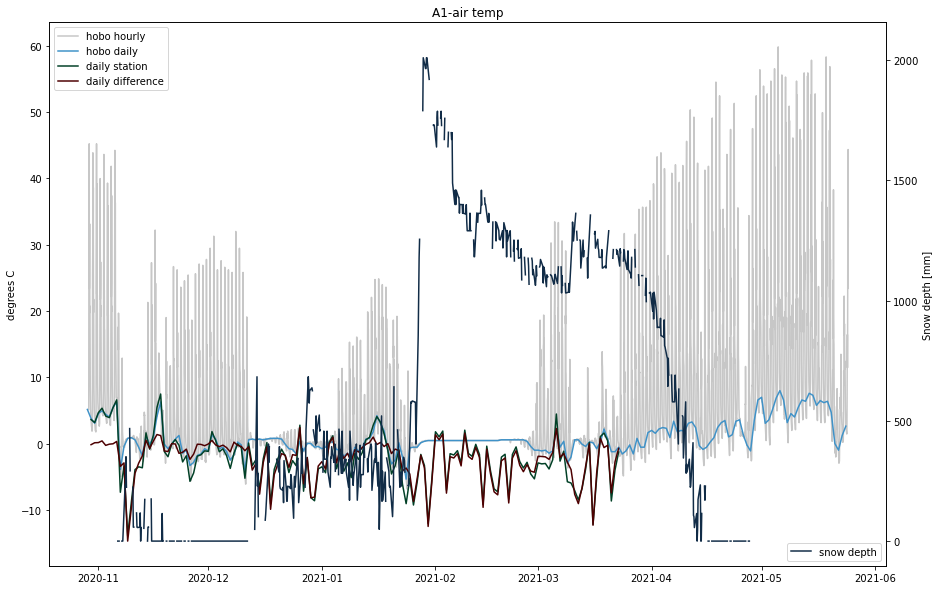

In [21]:

hobo = pd.read_csv('hoboA1.csv',header=1)
kh = hobo.keys()
hobo['dt']=pd.to_datetime(hobo[kh[1]])

station = pd.read_csv('TableA1.csv',header=0)
station['dt'] = pd.to_datetime(station['TIMESTAMP'])
ks = station.keys()
station_wy20 = station[station['dt']>hobo['dt'][0]]
hobo_T=pd.Series(hobo[kh[2]])
hobo_T.index=hobo['dt']
station_T=pd.Series(station_wy20['AirTC_Avg'])
station_T.index = station_wy20['dt']
station_hourly = station_T.resample('1H').bfill()
hobo_hourly = hobo_T.resample('1H').bfill()
station_daily = station_T.resample('24H').bfill()
hobo_daily = hobo_T.resample('24H').bfill()
hourly_temps = pd.DataFrame(hobo_hourly).join(pd.DataFrame(station_hourly))
hourly_temps.columns=['hobo','station']
daily_temps = pd.DataFrame(hobo_daily).join(pd.DataFrame(station_daily))
daily_temps.columns=['hobo','station']
hourly_temps['hobo c'] = (hourly_temps['hobo'] - 32) / 1.8  
hourly_temps['difference'] = hourly_temps['station'].astype('float')-hourly_temps['hobo c']
series=pd.Series(station_wy20['AirTC_Avg'].astype('float'))

daily_temps['hobo c'] = (daily_temps['hobo'] - 32) / 1.8  
daily_temps['difference'] = daily_temps['station'].astype('float')-daily_temps['hobo c']

camera = pd.read_csv('snowsummary_wetland.csv',header=2)
camera['dt'] = pd.to_datetime(camera['Date'])
camera_wy20 = camera[camera['dt']>hobo['dt'][0]]
camera_wy20.index = camera_wy20['dt']


cols = cm.bukavu(np.linspace(0,1,5))
y = daily_temps['hobo c'].astype('float')
x = daily_temps.index

f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(hourly_temps.index,hourly_temps['hobo c'],color=cm.grayC(50),label='hobo hourly')
ax.plot(x,y,color=cols[1],label='hobo daily')
daily_station = daily_temps['station'].astype('float') #  savgol_filter(hourly_temps['station'].astype('float'), window_length = 1, polyorder = 1)
tmp =  daily_station - y
ax.plot(x,daily_station,color=cols[2],label='daily station')
ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('degrees C')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
ax.set_title('A1-air temp')
plt.savefig("snow_temp_a1_air.jpg", dpi=300)

/Users/marianne/opt/anaconda3/envs/earthenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


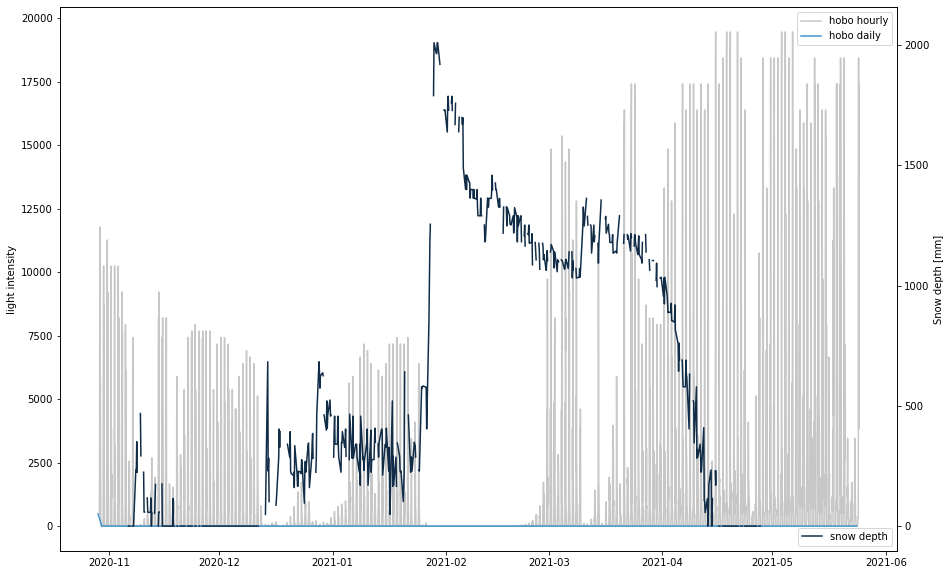

In [37]:

hobo = pd.read_csv('hoboA1.csv',header=1)
kh = hobo.keys()
hobo['dt']=pd.to_datetime(hobo[kh[1]])

station = pd.read_csv('TableA1.csv',header=0)
station['dt'] = pd.to_datetime(station['TIMESTAMP'])
ks = station.keys()
station_wy20 = station[station['dt']>hobo['dt'][0]]
hobo_I=pd.Series(hobo[kh[3]])
hobo_I.index=hobo['dt']
station_T=pd.Series(station_wy20['AirTC_Avg'])
station_T.index = station_wy20['dt']
station_hourly = station_T.resample('1H').bfill()
hobo_hourly = hobo_I.resample('1H').bfill()
station_daily = station_T.resample('24H').bfill()
hobo_daily = hobo_I.resample('24H').bfill()
hourly_temps = pd.DataFrame(hobo_hourly).join(pd.DataFrame(station_hourly))
hourly_temps.columns=['hobo','station']
daily_temps = pd.DataFrame(hobo_daily).join(pd.DataFrame(station_daily))
daily_temps.columns=['hobo','station']
hourly_temps['hobo i'] = (hourly_temps['hobo']) # - 32) / 1.8  
# hourly_temps['difference'] = hourly_temps['station'].astype('float')-hourly_temps['hobo c']
series=pd.Series(station_wy20['AirTC_Avg'].astype('float'))

daily_temps['hobo i'] = (daily_temps['hobo']) # - 32) / 1.8  
# daily_temps['difference'] = daily_temps['station'].astype('float')-daily_temps['hobo c']

camera = pd.read_csv('snowsummary_wetland.csv',header=2)
camera['dt'] = pd.to_datetime(camera['Date'])
camera_wy20 = camera[camera['dt']>hobo['dt'][0]]
camera_wy20.index = camera_wy20['dt']


cols = cm.bukavu(np.linspace(0,1,5))
y = daily_temps['hobo i'].astype('float')
x = daily_temps.index

f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(hourly_temps.index,hourly_temps['hobo i'],color=cm.grayC(50),label='hobo hourly')
ax.plot(x,y,color=cols[1],label='hobo daily')
# daily_station = daily_temps['station'].astype('float') #  savgol_filter(hourly_temps['station'].astype('float'), window_length = 1, polyorder = 1)
# tmp =  daily_station - y
#ax.plot(x,daily_station,color=cols[2],label='daily station')
# ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('light intensity')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
# ax.set_title('A1-air temp')
# plt.savefig("snow_temp_a1_air.jpg", dpi=300)

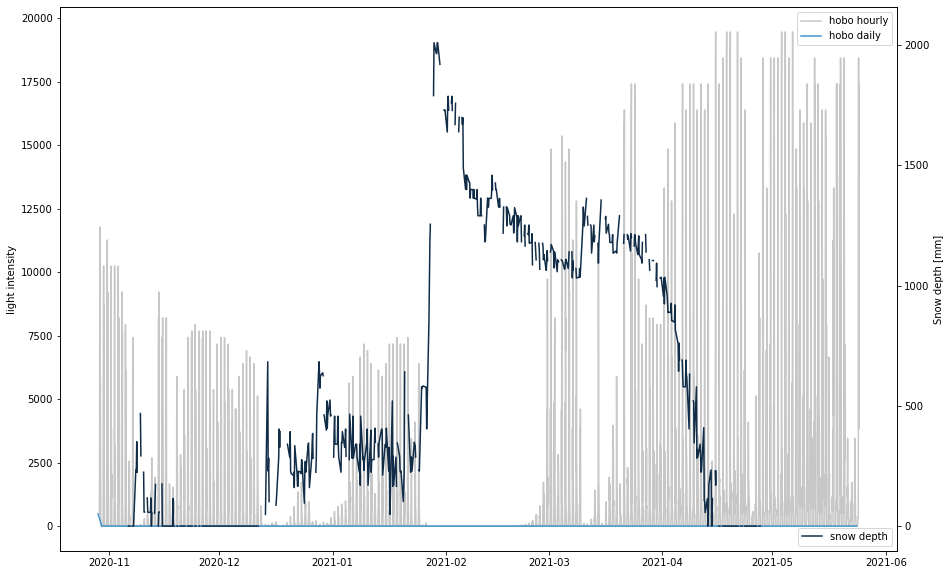

In [36]:
y = daily_temps['hobo i'].astype('float')
x = daily_temps.index
f,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(hourly_temps.index,hourly_temps['hobo i'],color=cm.grayC(50),label='hobo hourly')
ax.plot(x,y,color=cols[1],label='hobo daily')
# daily_station = daily_temps['station'].astype('float') #  savgol_filter(hourly_temps['station'].astype('float'), window_length = 1, polyorder = 1)
# tmp =  daily_station - y
#ax.plot(x,daily_station,color=cols[2],label='daily station')
# ax.plot(x,tmp, color=cm.bilbao(255),label = 'daily difference')
ax2.plot(camera_wy20['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('light intensity')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
plt.show()
# ax.set_title('A1-air temp')
# plt.savefig("snow_temp_a1_air.jpg", dpi=300)

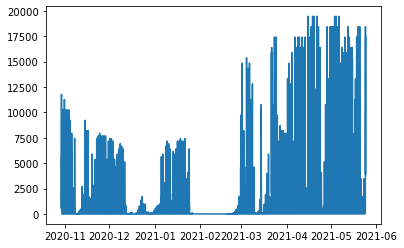

In [35]:
plt.plot(hourly_temps['hobo i'])

In [26]:
hobo.keys()

Index(['#', 'Date Time, GMT-07:00',
       'Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)',
       'Intensity, lum/ft² (LGR S/N: 20947454, SEN S/N: 20947454)',
       'Coupler Attached (LGR S/N: 20947454)',
       'Coupler Detached (LGR S/N: 20947454)',
       'Host Connected (LGR S/N: 20947454)', 'End Of File (LGR S/N: 20947454)',
       'dt'],
      dtype='object')